# Introduction

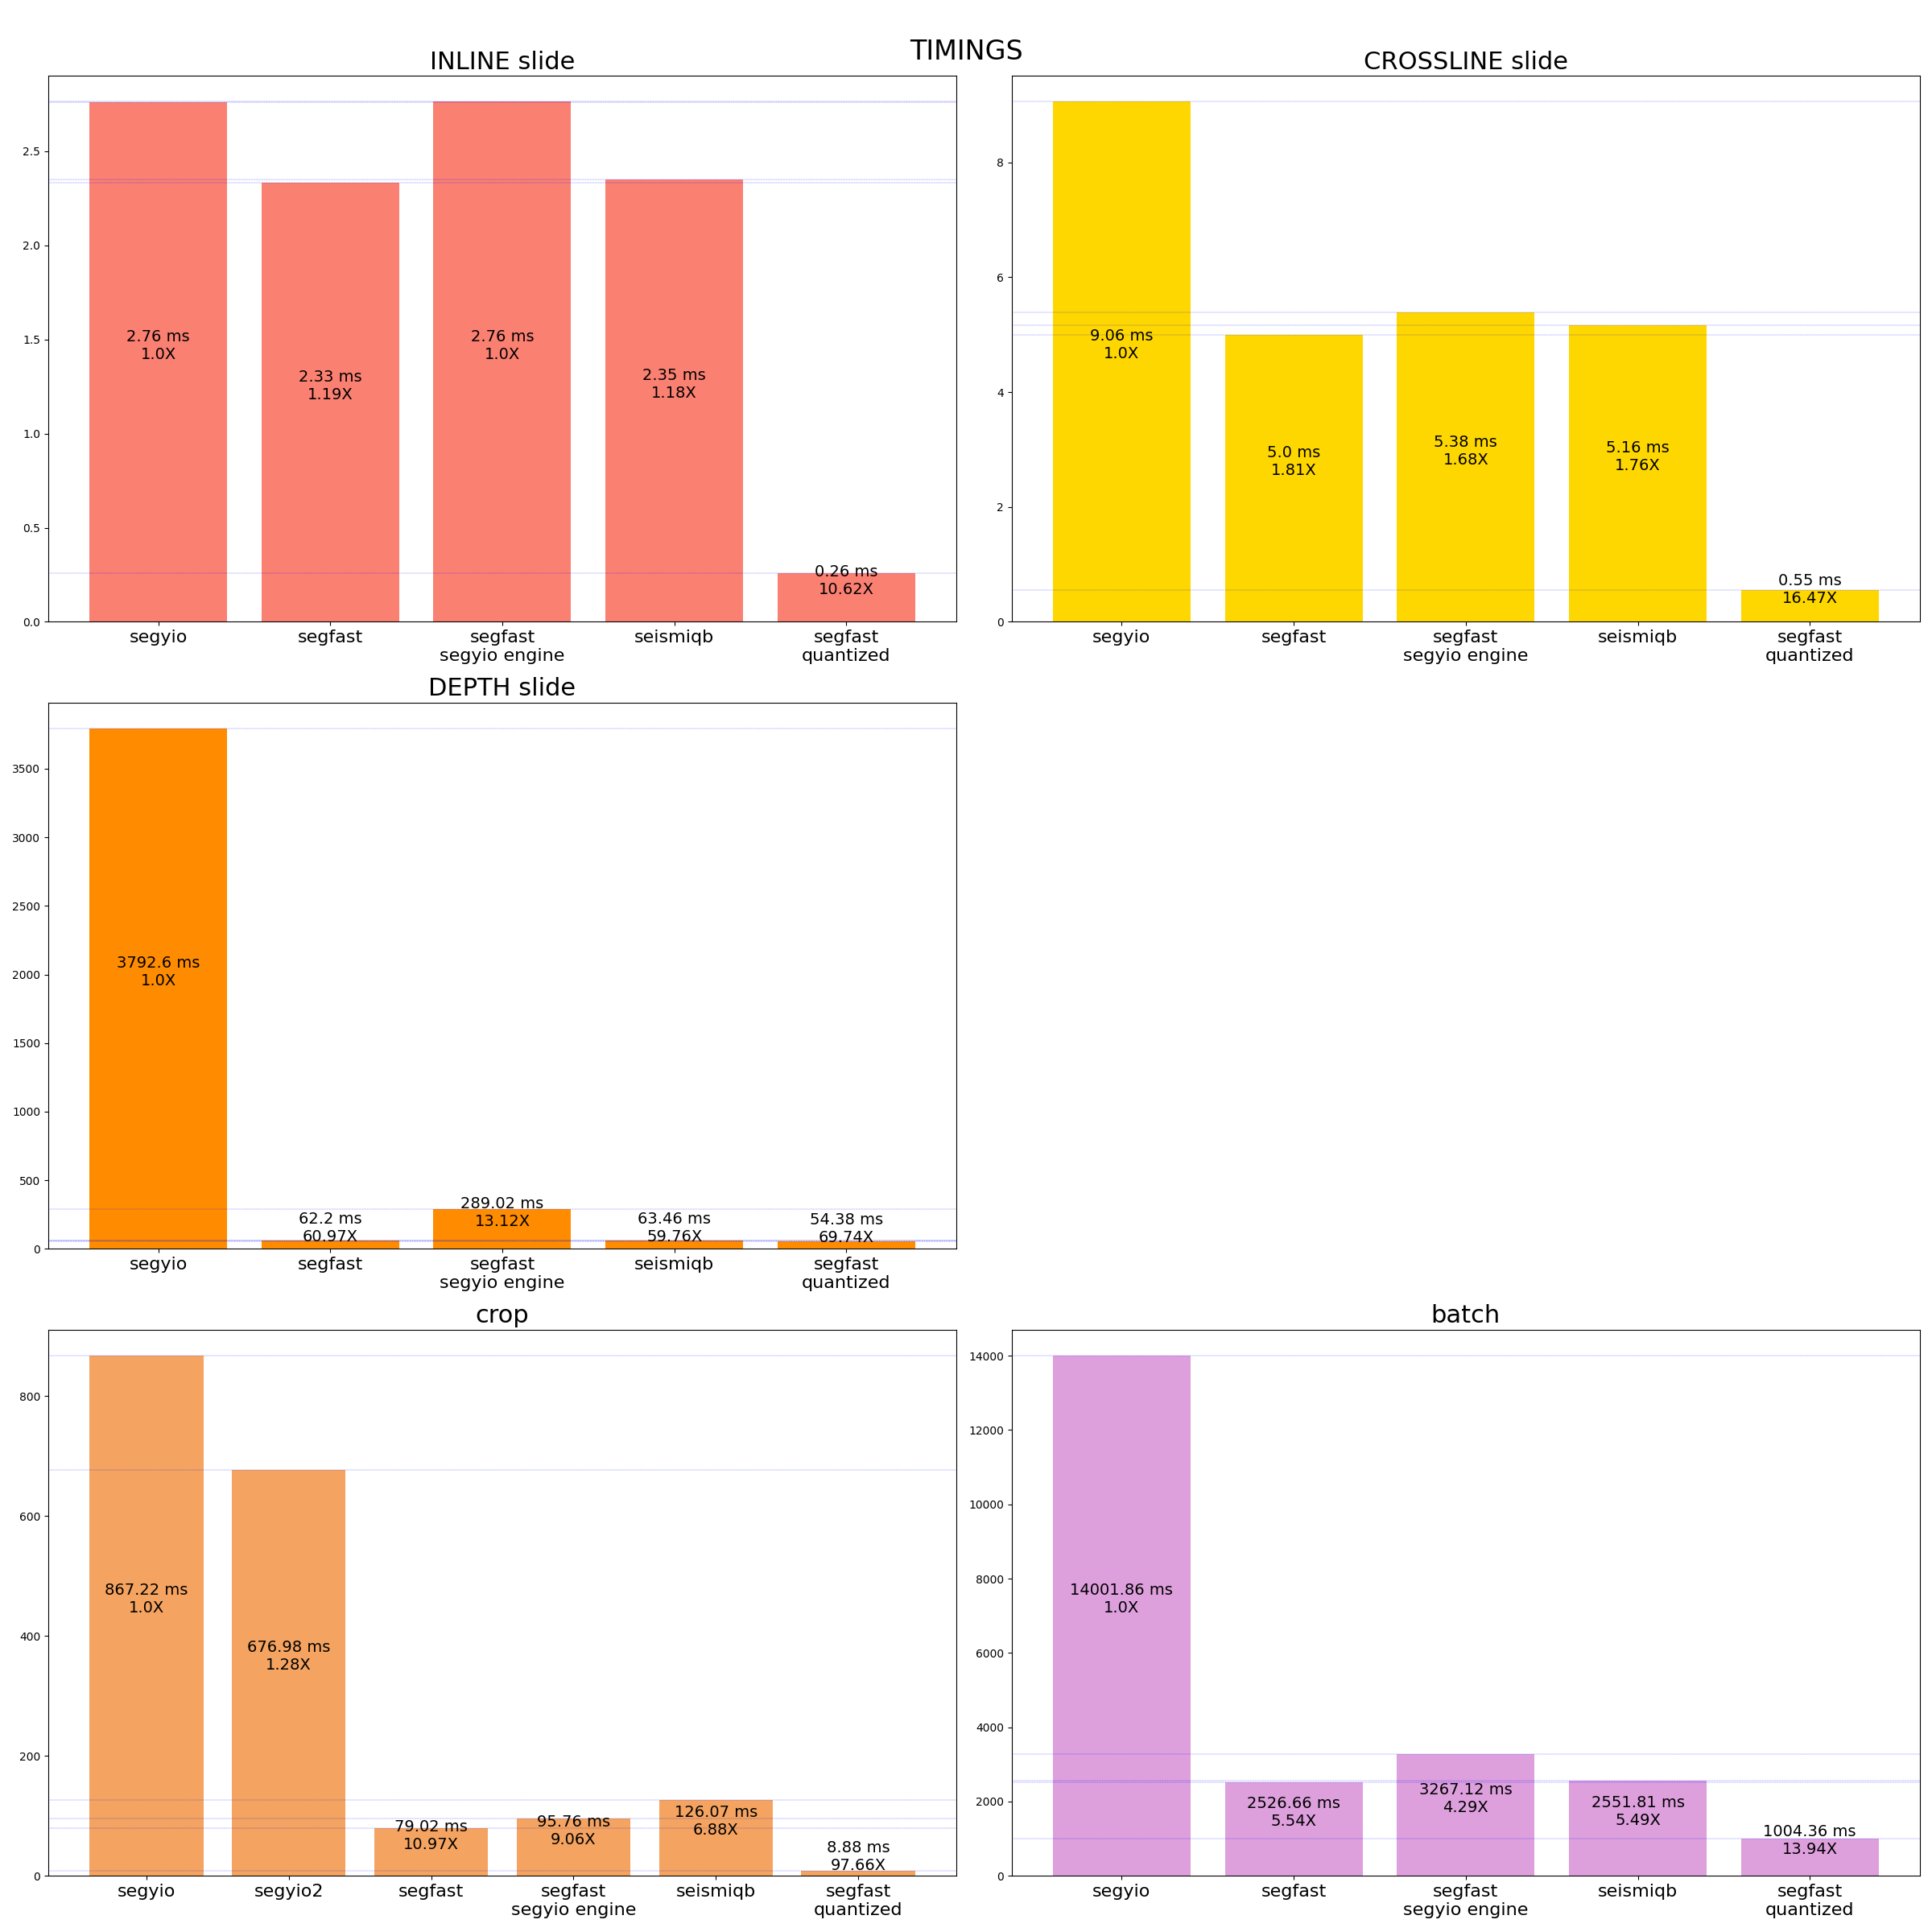

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pickle
from time import perf_counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import segyio

sys.path.insert(0, '..')
import segfast

sys.path.insert(0, '../../seismiqb')
from seismiqb import Geometry

In [2]:
path = 'data/A.sgy'
size = os.path.getsize(path) / (1024 ** 3)
print(f'Input SEG-Y file size: {size:3.2f} GB')

idx = 555

Input SEG-Y file size: 21.00 GB


# Basic

In [3]:
segyio_file = segyio.open(path, strict=True, ignore_geometry=False)
n_ilines, n_xlines = len(segyio_file.ilines), len(segyio_file.xlines)

idx_ = segyio_file.ilines[idx]
slide_segyio_i = segyio_file.iline[idx_]

In [4]:
segfast_file = segfast.open(path=path)

# Context manager: recommended
with segfast.open(path=path) as file:
    print(file.path, file.sample_interval, file.sample_rate)

data/A.sgy 2.0 500.0


In [5]:
with open('tester.pckl', 'wb') as file:
    pickle.dump(segfast_file, file)

with open('tester.pckl', 'rb') as file:
    reloaded = pickle.load(file)

print(reloaded.path, reloaded.sample_interval, reloaded.sample_rate)

data/A.sgy 2.0 500.0


In [6]:
start = idx * n_xlines
stop = start + n_xlines
indices = range(start, stop)

slide_segfast_i = segfast_file.load_traces(indices=indices)

np.allclose(slide_segyio_i, slide_segfast_i)

True

# Headers

In [7]:
requested_headers = ['INLINE_3D', 'CROSSLINE_3D']

In [8]:
%%time
headers_segfast = segfast_file.load_headers(requested_headers)

headers_segfast.head()

CPU times: user 123 ms, sys: 151 ms, total: 274 ms
Wall time: 636 ms


,TRACE_SEQUENCE_FILE,INLINE_3D,CROSSLINE_3D
0,1,24,19
1,2,24,20
2,3,24,21
3,4,24,22
4,5,24,23


In [9]:
%%time
headers_segyio = pd.DataFrame({header : segyio_file.attributes(getattr(segyio.TraceField, header))
                               for header in requested_headers})

headers_segyio.head()

CPU times: user 2.71 s, sys: 7.55 s, total: 10.3 s
Wall time: 10.2 s


,INLINE_3D,CROSSLINE_3D
0,24,19
1,24,20
2,24,21
3,24,22
4,24,23


In [10]:
flag = (headers_segfast[requested_headers] == headers_segyio[requested_headers]).all().all()
print('Loaded equal headers:', flag)

Loaded equal headers: True


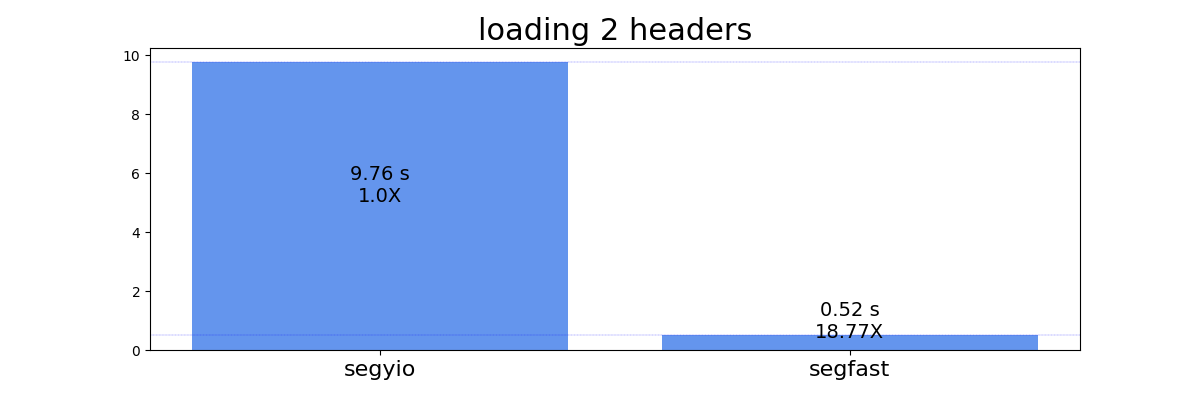

# segfast with segyio engine

In [11]:
segfast_file_ = segfast.open(path=path, engine='segyio')

In [12]:
slide_segfast_i_ = segfast_file_.load_traces(indices=indices)

np.allclose(slide_segfast_i_, slide_segfast_i)

True

# POST-STACK cubes: seismiqb

In [13]:
seismiqb_file = Geometry.new(path)

In [14]:
slide_seismiqb_i = seismiqb_file.load_slide(idx)

np.allclose(slide_segyio_i, slide_seismiqb_i)

True

# Export data

In [15]:
%%time
def transform(array):
    return (2 * array).astype('>f4')

path_out = path.replace('.sgy', '_TESTCOPY_SEGFAST.sgy')

segfast_file.convert(path=path_out, transform=transform, format=5)

Convert to `A_TESTCOPY_SEGFAST.sgy`: 100%|██████████████████████| 3611267/3611267 [00:16<00:00, 214162.04it/s]
CPU times: user 257 ms, sys: 91.9 ms, total: 349 ms
Wall time: 16.9 s


'data/A_TESTCOPY_SEGFAST.sgy'

In [16]:
reopened = segfast.File(path_out)

np.allclose(segfast_file.load_traces(indices) * 2,
            reopened.load_traces(indices))

True

In [17]:
%%time
array = seismiqb_file[:, :, :]
array.shape, array.nbytes / (1024 ** 3)

CPU times: user 7.66 s, sys: 8.6 s, total: 16.3 s
Wall time: 16.3 s


((2563, 1409, 1501), 20.192979898303747)

In [18]:
%%time
path_out = path.replace('.sgy', '_TESTCOPY_SEISMIQB.sgy')

seismiqb_file.export_array(array, path_out)

Writing `A_TESTCOPY_SEISMIQB.sgy`: 100%|███| 2563/2563 [00:11<00:00, 231.93it/s]
CPU times: user 6.58 s, sys: 34.7 s, total: 41.3 s
Wall time: 11.3 s


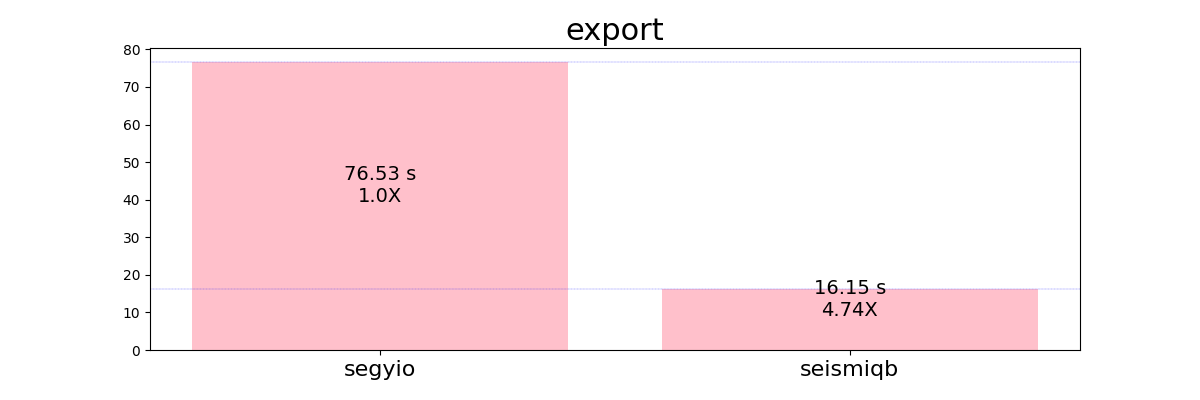

## Quantization

In [19]:
%%time
path_out = path.replace('.sgy', '_QUANTIZED.sgy')
seismiqb_file.convert(path=path_out, quantize=True)

Convert to `A_QUANTIZED.sgy`: 100%|██████████████████████████████| 3611267/3611267 [00:40<00:00, 88153.50it/s]
CPU times: user 1min 28s, sys: 4.84 s, total: 1min 33s
Wall time: 1min 6s


<Processed geometry `A_QUANTIZED`: (2563, 1409, 1501) at 0x7f96df95daf0>

In [20]:
segfast_file_q = segfast.File(path_out)
size = os.path.getsize(path_out) / (1024 ** 3)
print(f'Quantized file size: {size:3.2f} GB')

Quantized file size: 5.86 GB


In [21]:
slide_segfast_q_i = segfast_file_q.load_traces(indices)

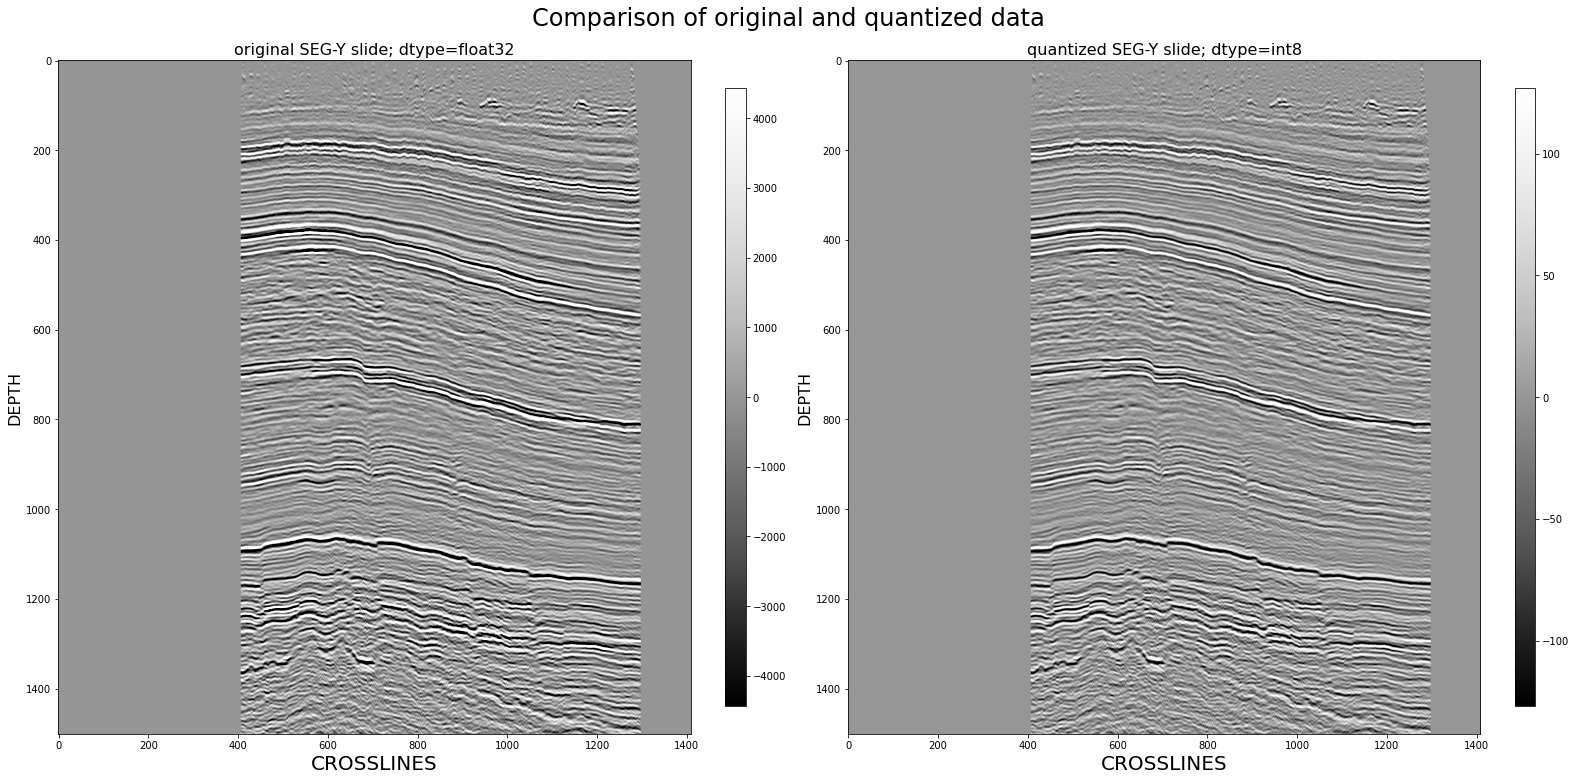

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(22, 11))

vmin, vmax = np.quantile(slide_segfast_i, (0.01, 0.99))
img = ax[0].imshow(slide_segfast_i.T, cmap='Greys_r', vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax[0], fraction=0.03, aspect=30)
ax[0].set_title(f'original SEG-Y slide; dtype={slide_segfast_i.dtype}', fontsize=16)

img = ax[1].imshow(slide_segfast_q_i.T, cmap='Greys_r')
plt.colorbar(img, ax=ax[1], fraction=0.03, aspect=30)
ax[1].set_title(f'quantized SEG-Y slide; dtype={slide_segfast_q_i.dtype}', fontsize=16)

for ax_ in ax:
    ax_.set_xlabel('CROSSLINES', fontsize=20)
    ax_.set_ylabel('DEPTH', fontsize=16)

fig.suptitle('Comparison of original and quantized data', fontsize=24)
fig.tight_layout()
fig.show()